# Building A Suicide Text Classifier

## Importing Library

In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [0]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

## Loading The Dataset

In [0]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/Sucide_Detect_Combined.csv')

In [8]:
df.head()

,subreddit,selftext,title,name,is_sucide
0,SuicideWatch,We've been seeing a worrying increase in pro-s...,New wiki on how to avoid accidentally encourag...,t3_cz6nfd,1
1,SuicideWatch,"If you want to recognise an occasion, please d...",Reminder: Absolutely no activism of any kind i...,t3_d2370x,1
2,SuicideWatch,All I want is to be a normal person who can ju...,"Every time I feel optimistic, every time I thi...",t3_gt6nhf,1
3,SuicideWatch,Original post: https://www.reddit.com/r/Suicid...,Wife cheated update,t3_gtdvnt,1
4,SuicideWatch,Basically the title. Every time I or some one ...,How come I can't choose suicide as an option? ...,t3_gt6tdi,1


## Suffling The dataset

In [0]:
df = df.sample(frac=1).reset_index(drop=True)

In [10]:
df.shape

(1932, 5)

In [11]:
df.isnull().sum()

subreddit     0
selftext     49
title         0
name          0
is_sucide     0
dtype: int64

## Cleaning Data

In [0]:
df['selftext']=df['selftext'].fillna('No Text')

In [0]:
wordnet=WordNetLemmatizer()

In [0]:
def clean_text(a):
    x=re.sub('[^a-zA-Z]',' ',a)
    x=x.lower()
    text=nltk.word_tokenize(x)
    text=[wordnet.lemmatize(word) for word in text if word not in stopwords.words('english')]
    text=' '.join(text)
    return text

In [0]:
df['selftext']=df['selftext'].apply(clean_text)

In [16]:
df.head()

,subreddit,selftext,title,name,is_sucide
0,depression,posted yesterday wondering anyone else thing c...,And it's all fucking back,t3_gsu2k6,0
1,depression,pls need view long take get back normal reach ...,Reaching Steady State On Lexapro After Missing...,t3_gta7rm,0
2,depression,frustrated yesterday able productive today den...,I hate how inconsistent depression is,t3_gshzwv,0
3,SuicideWatch,made new reddit account case anyone know see a...,I can’t clear my head.,t3_gt8onw,1
4,SuicideWatch,probably pretty common raised cult strict rule...,"I'm a pebble, dreaming about being a tree.",t3_gs0mw4,1


In [0]:
text=df['selftext']

In [0]:
target=df['is_sucide']

In [0]:
x_train,x_test,y_train,y_test=train_test_split(text,target,random_state=42,test_size=0.2)

## Tokenizing and Paddding

In [0]:
tokenizer=Tokenizer()

In [0]:
tokenizer.fit_on_texts(text)

In [24]:
word_index=tokenizer.word_index
vocab_size=len(word_index)+1
vocab_size

9900

In [25]:
train_sequence=tokenizer.texts_to_sequences(x_train)
max_len=max(len(words) for words in train_sequence)
max_len

942

In [0]:
train_sequence=tokenizer.texts_to_sequences(x_train)
max_len=max(len(words) for words in train_sequence)
train_padded=pad_sequences(train_sequence,maxlen=max_len)

In [0]:
test_sequence=tokenizer.texts_to_sequences(x_test)
test_padded=pad_sequences(test_sequence,maxlen=max_len)

In [31]:
# Used a api of globe for faster access
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size,100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-05-30 17:02:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.128, 2607:f8b0:4001:c11::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   143MB/s    in 2.3s    

2020-05-30 17:02:28 (143 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



## Building The Model

In [0]:
model=Sequential()

In [0]:
model.add(Embedding(vocab_size,100, input_length=max_len, weights=[embeddings_matrix], trainable=False))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(326,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(625)))
model.add(Dense(1,activation='sigmoid'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 942, 100)          990000    
_________________________________________________________________
dropout (Dropout)            (None, 942, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 942, 652)          1113616   
_________________________________________________________________
dropout_1 (Dropout)          (None, 942, 652)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1250)              6390000   
_________________________________________________________________
dense (Dense)                (None, 1)                 1251      
Total params: 8,494,867
Trainable params: 7,504,867
Non-trainable params: 990,000
________________________________________

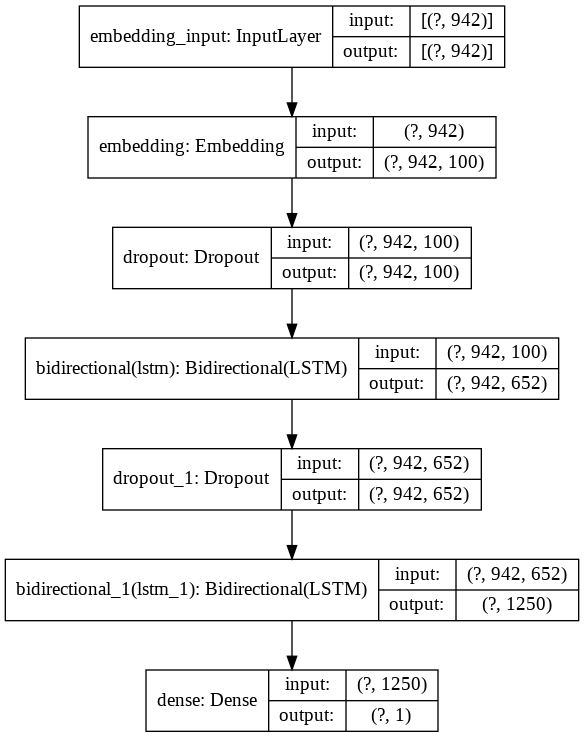

In [35]:
plot_model(model, show_shapes=True)

In [0]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
filepath = os.path.join("./sucide_models/model_v{epoch}.hdf5")

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
callbacks = [checkpoint]

In [38]:
history=model.fit(train_padded,y_train,epochs=20,validation_data=(test_padded,y_test),callbacks=callbacks)

Epoch 1/20
49/49 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.5385
Epoch 00001: val_accuracy improved from -inf to 0.63566, saving model to ./sucide_models/model_v1.hdf5
49/49 [==============================] - 94s 2s/step - loss: 0.6951 - accuracy: 0.5385 - val_loss: 0.6582 - val_accuracy: 0.6357
Epoch 2/20
49/49 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.6110
Epoch 00002: val_accuracy did not improve from 0.63566
49/49 [==============================] - 92s 2s/step - loss: 0.6511 - accuracy: 0.6110 - val_loss: 0.6470 - val_accuracy: 0.6202
Epoch 3/20
49/49 [==============================] - ETA: 0s - loss: 0.6422 - accuracy: 0.6317
Epoch 00003: val_accuracy did not improve from 0.63566
49/49 [==============================] - 92s 2s/step - loss: 0.6422 - accuracy: 0.6317 - val_loss: 0.6472 - val_accuracy: 0.6357
Epoch 4/20
49/49 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.6375
Epoch 00004: val_accurac

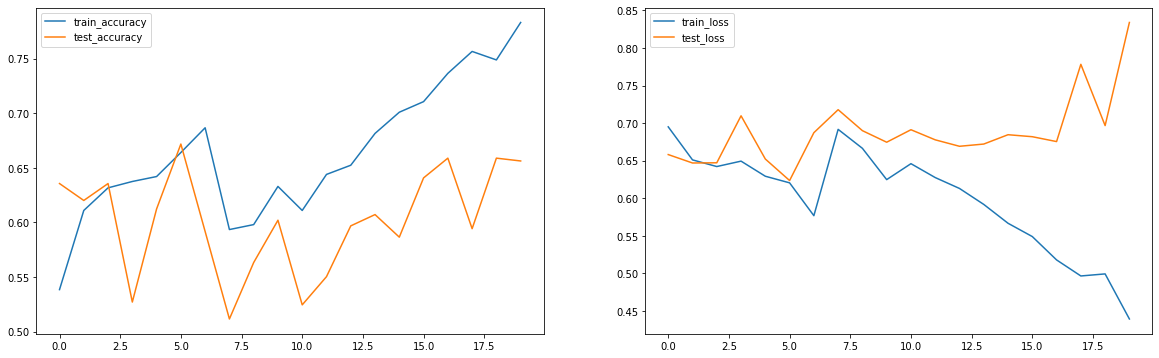

In [39]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(20,6))
ax1.plot(history.history['accuracy'],label='train_accuracy')
ax1.plot(history.history['val_accuracy'],label='test_accuracy')
ax1.legend()
ax2.plot(history.history['loss'],label='train_loss')
ax2.plot(history.history['val_loss'],label='test_loss')
ax2.legend()
plt.show()

## Loading Model and Checking Accuracy

In [0]:
classifier=load_model('/content/sucide_models/model_v6.hdf5')

In [0]:
prediction=classifier.predict(test_padded)

In [0]:
pr=(prediction>0.5)

In [43]:
print(confusion_matrix(y_test,pr))

[[154  48]
 [ 79 106]]


In [44]:
print(classification_report(y_test,pr))

              precision    recall  f1-score   support

           0       0.66      0.76      0.71       202
           1       0.69      0.57      0.63       185

    accuracy                           0.67       387
   macro avg       0.67      0.67      0.67       387
weighted avg       0.67      0.67      0.67       387



## Predicting On New Messages

In [0]:
import pickle 
with open('tokenizer.pkl','wb') as f:
  pickle.dump(tokenizer,f)

In [0]:
#Depression Thought
text1='''I don't know, it's like this unexplainable feeling. 
Like this physical feeling in my heart that pulsates throughout my whole being. 
Whenever I hear happy music or watch a cheesy movie where everybody's happy I just can't help but feel sad. 
Same thing if I see something from when I was a kid or something similar. 
I'm thinking the root of it may be I've felt like I've missed out on life or didn't make the most of it? 
I don't know. I'm just hoping it's not just me.'''

In [0]:
tokens=tokenizer.texts_to_sequences([text1])
padded=pad_sequences(tokens,maxlen=max_len)

In [0]:
predict=classifier.predict(padded)

In [50]:
pr=(predict>0.5)
if pr[0][0]==False:
  print("Depression")
else:
  print("Sucide")

Depression


In [0]:
#Sucide Thought
text2=''' It's been a year. An entire fucking year that I gave myself another chance. 
Or more like gave him another chance. Last year in October, I came close to killing myself. 
I had thought that nothing would ever get better and that there was absolutely no point living in a life that was FOR SURE never going to get better.
Yet, I gave God another chance. That morning, a pack of coyotes howled during the sunset as the last song in my playlist of songs I want played in my funeral had ended.
After hearing the coyotes, I thought it was a sign. A sign that God would make it better. 
'''

In [0]:
tokens=tokenizer.texts_to_sequences([text2])
padded=pad_sequences(tokens,maxlen=942)

In [0]:
predict=classifier.predict(padded)

In [60]:
pr=(predict>0.5)
if pr[0][0]==False:
  print("Depression")
else:
  print("Sucide")

Sucide


### Saving Model as TFJS for further use

In [0]:
!tensorflowjs_converter --input_format keras '/content/sucide_models/model_v6.hdf5' './js_model'

In [66]:
!zip -r tfjs_models.zip /content/js_model

  adding: content/js_model/ (stored 0%)
  adding: content/js_model/group1-shard9of9.bin (deflated 23%)
  adding: content/js_model/group1-shard2of9.bin (deflated 7%)
  adding: content/js_model/group1-shard6of9.bin (deflated 7%)
  adding: content/js_model/group1-shard8of9.bin (deflated 13%)
  adding: content/js_model/model.json (deflated 80%)
  adding: content/js_model/.ipynb_checkpoints/ (stored 0%)
  adding: content/js_model/group1-shard3of9.bin (deflated 7%)
  adding: content/js_model/group1-shard1of9.bin (deflated 7%)
  adding: content/js_model/group1-shard7of9.bin (deflated 7%)
  adding: content/js_model/group1-shard4of9.bin (deflated 7%)
  adding: content/js_model/group1-shard5of9.bin (deflated 7%)


## Conclusion:
* Model achived an highest accuracy of 67%
* It Predicted the output correctly, but model accuracy needs to be improved